<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#直接贪心法，sensor按照节点顺序连接client" data-toc-modified-id="直接贪心法，sensor按照节点顺序连接client-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>直接贪心法，sensor按照节点顺序连接client</a></span></li><li><span><a href="#最近邻贪心法，sensor连接最近的5个client" data-toc-modified-id="最近邻贪心法，sensor连接最近的5个client-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>最近邻贪心法，sensor连接最近的5个client</a></span></li><li><span><a href="#GA启发式" data-toc-modified-id="GA启发式-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>GA启发式</a></span></li></ul></div>

In [13]:
import numpy as np
import collections
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import random 
import copy
%matplotlib inline

In [4]:
P_1v1 = 0.044006

In [32]:
NUM_OF_SENSORS = 100
NUM_OF_CLIENTS = 100
SERVERS_CONNECT_ABILITY = 5
CLIENT_CONNECT_NEED = 3
SENSOR_DISTANCE = 50
LENGTH_OF_SQUARE = 400

maxiter = 100
SIZE = 10

CROSSOVER_RATE = 0.5
MUTATION_RATE = 0.001

In [6]:

def init_nodes_and_distance_matrix(seed=15):
    '''
    初始化传感器sensors, 被感知节点clients 和 距离矩阵 distances
    sensors: array, (100,2)
    clients: array, (100,2)
    distances: array, (100,100), 大于等于50的距离直接置为inf
    '''
    sensors = []
    clients = []
    distances = np.ones((NUM_OF_SENSORS,NUM_OF_CLIENTS))
    np.random.seed(seed)
    for i in range(NUM_OF_SENSORS):
        sensors.append([np.random.uniform(0,LENGTH_OF_SQUARE),np.random.uniform(0,LENGTH_OF_SQUARE)])
    for i in range(NUM_OF_CLIENTS):
        clients.append([np.random.uniform(0,LENGTH_OF_SQUARE),np.random.uniform(0,LENGTH_OF_SQUARE)])
        
    sensors = np.array(sensors)
    clients = np.array(clients)
    for i in range(NUM_OF_SENSORS):
        for j in range(NUM_OF_CLIENTS):
            dis = np.sqrt(np.sum(np.square(sensors[i] - clients[j])))
            distances[i][j] = dis if dis<=SENSOR_DISTANCE else float('inf')

    return sensors, clients, distances

    
sensors, clients, distances = init_nodes_and_distance_matrix()


tmp = np.zeros_like(distances)
tmp[distances<=50] = 1
tmp = np.sum(tmp, axis=0)
print("理论最高连接数：{}".format(np.sum(tmp>=3)))

理论最高连接数：71


In [7]:

# 绘图程序

def draw_picture(sensors, clients, distances, connection_matrix):
    f = plt.figure(figsize=(40,40))
    ax = plt.subplot(1,1,1)
    ax.scatter(sensors[:,0],sensors[:,1], c = 'r',marker='*')
    ax.scatter(clients[:,0],clients[:,1], c = 'b',marker='o')

    for i in range(NUM_OF_SENSORS): # 绘制所有在检测范围内的线
        for j in range(NUM_OF_CLIENTS):
            if distances[i][j] <= SENSOR_DISTANCE:
                ax.plot((sensors[i][0],clients[j][0]), (sensors[i][1],clients[j][1]), 'g-.')

    for i in range(NUM_OF_SENSORS): # 对于每一个sensor，绘制其检测范围内以最大连接能力可以连接的最近的点
        for j in range(NUM_OF_CLIENTS):
            if connection_matrix[i][j] == 1:
                ax.plot((sensors[i][0],clients[j][0]), (sensors[i][1],clients[j][1]), 'r-')
    
    for j in range(NUM_OF_CLIENTS): #绘制检测成功的client
        if np.sum(connection_matrix[:,j])>=CLIENT_CONNECT_NEED:
            ax.scatter(clients[j][0],clients[j][1], c = 'k',marker='o',s = 160)

    
    ax.set_ylim(0,LENGTH_OF_SQUARE)
    ax.set_xlim(0,LENGTH_OF_SQUARE)
    


##  直接贪心法，sensor按照节点顺序连接client

64


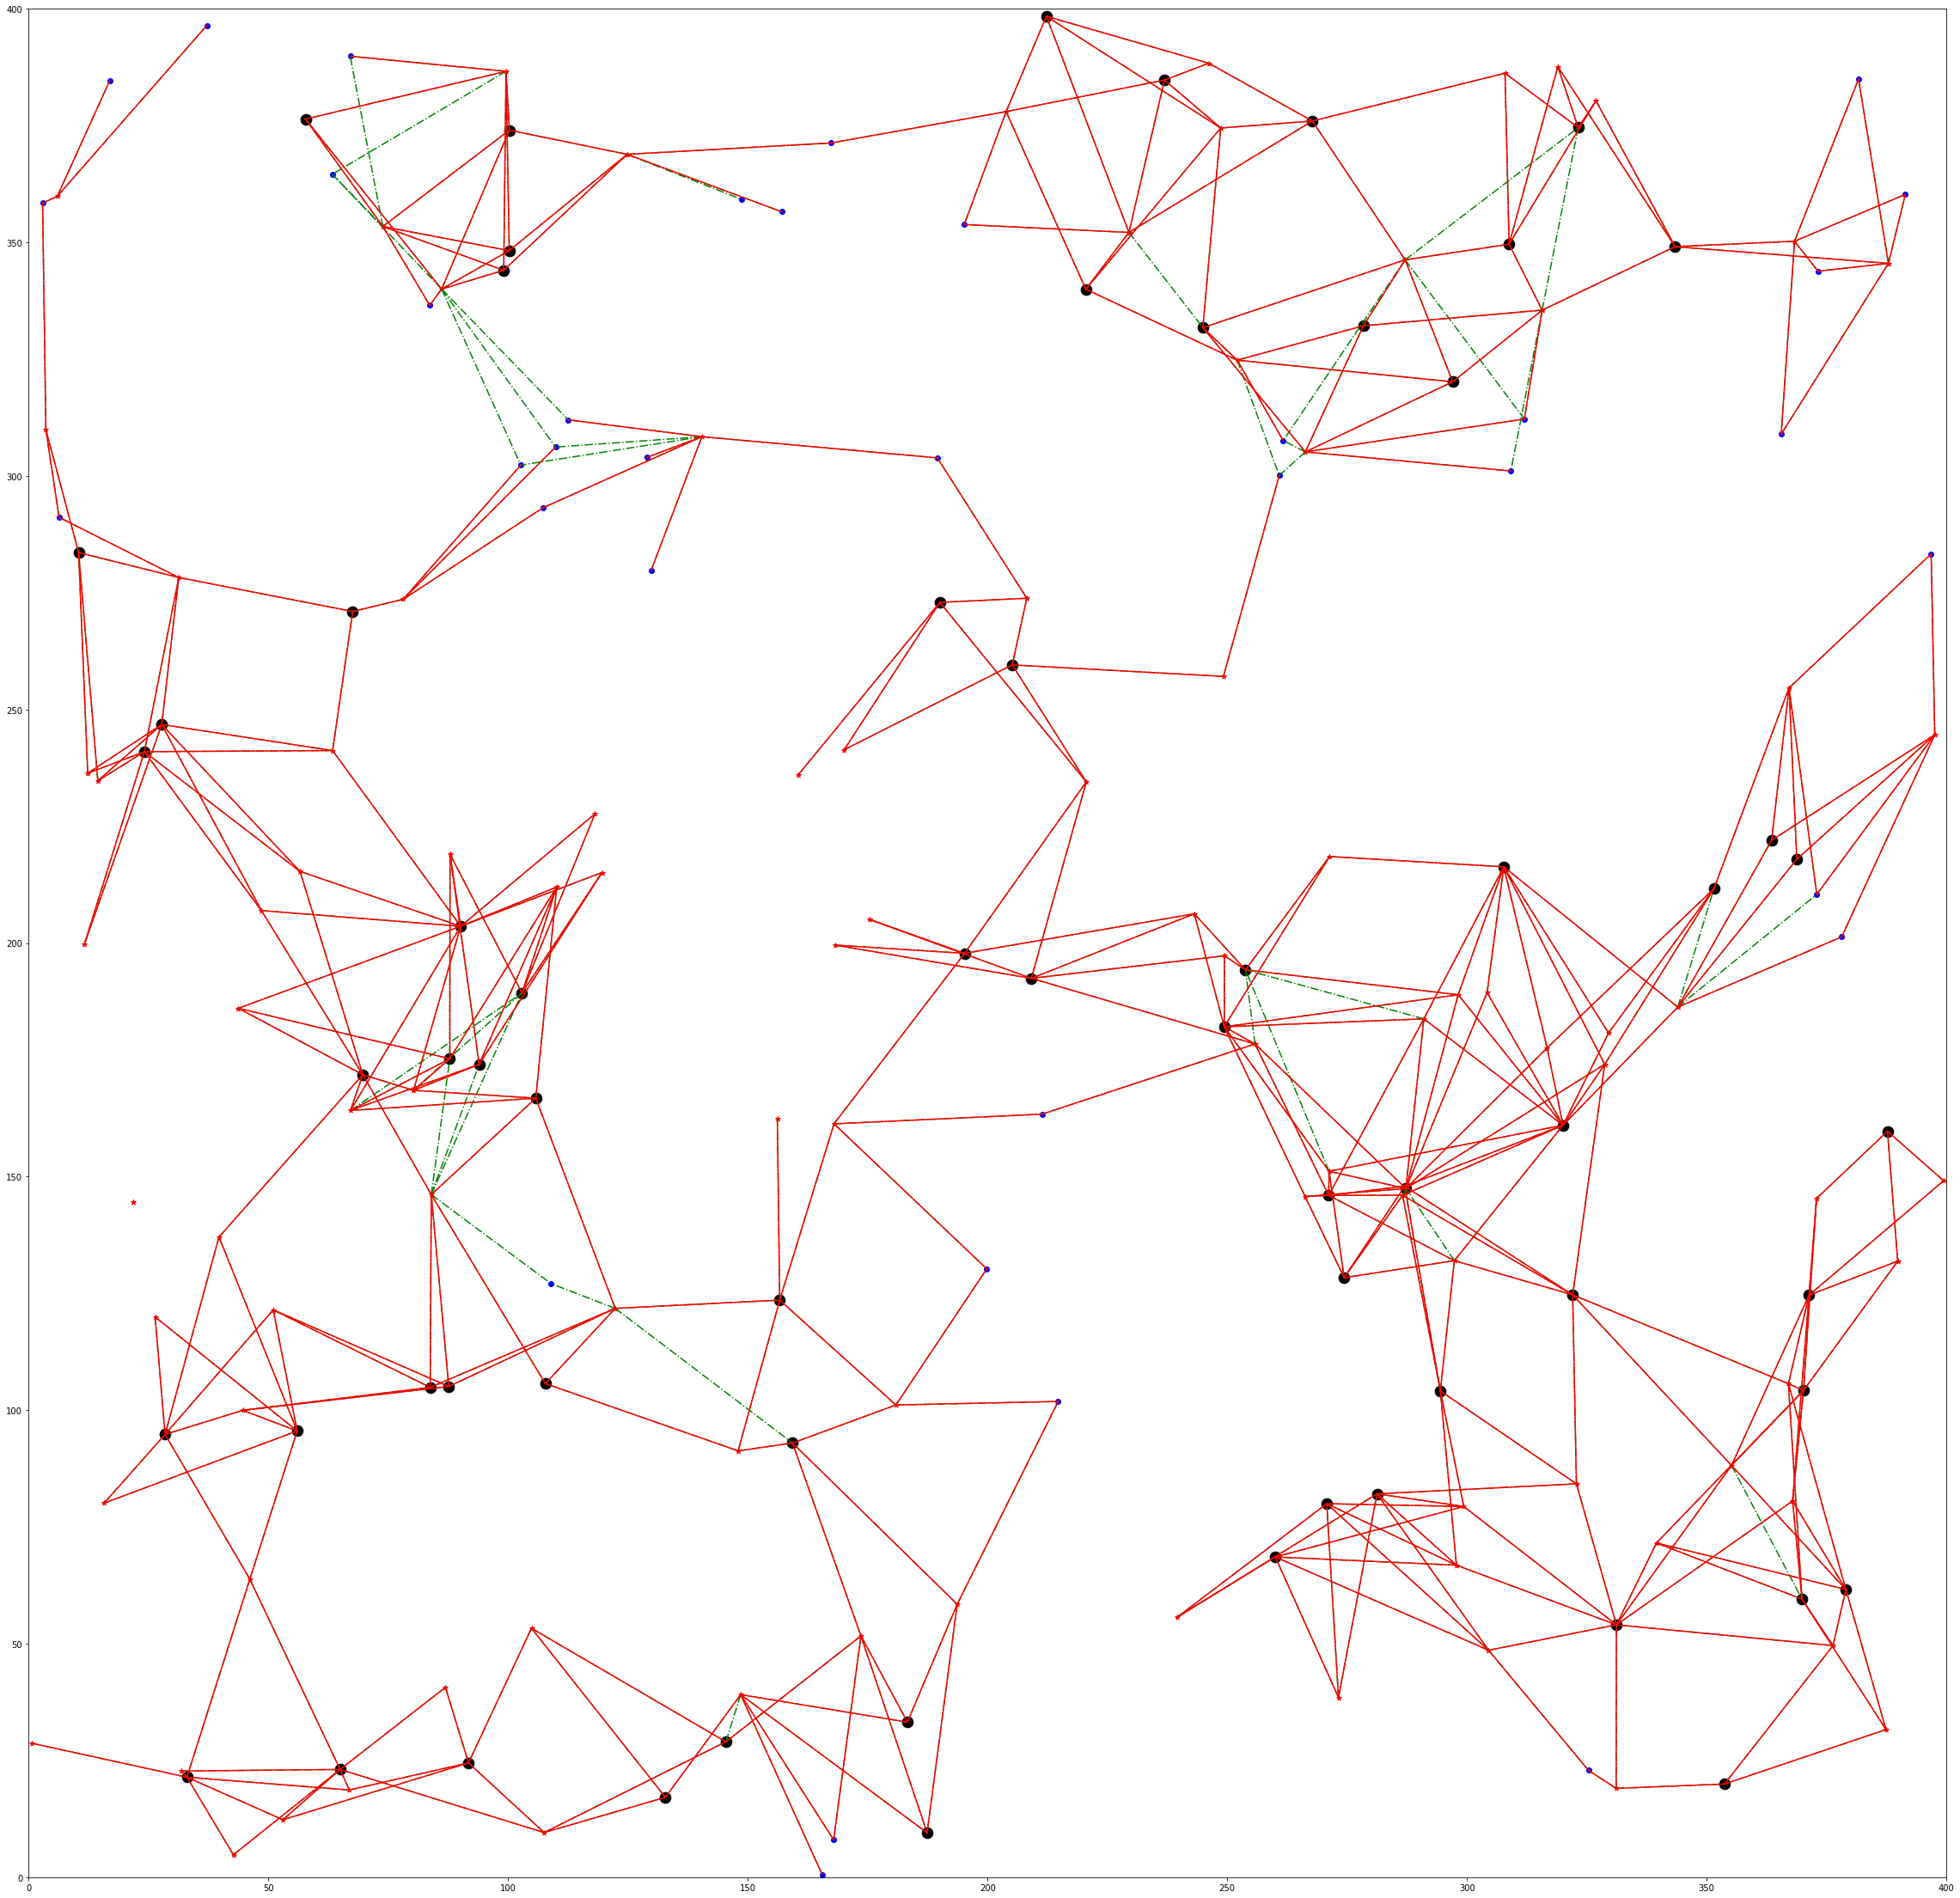

In [8]:
def greedy_direct(sensors, clients, distances):
    sensor_connecttion = np.zeros((NUM_OF_SENSORS,1))
    client_connecttion = np.zeros((NUM_OF_CLIENTS,1))
    connection_matrix = np.zeros((NUM_OF_SENSORS, NUM_OF_CLIENTS)) # connects_matrix[i][j]=1 代表i号sensor决定连接j号client
    # 这个函数用来储存每个sensor连接其检测能力下的最近的n个client, 也可以说是决定连接的client,不过没有必要最终使得每个决定连接的client都有足够多（CLIENT_CONNECT_NEED）个server连接
                
    for i in range(NUM_OF_SENSORS):
        for j in range(100):
            if (np.sum(np.square(sensors[i] - clients[j])) <= SENSOR_DISTANCE ** 2) and (sensor_connecttion[i][0] < 5) :
                sensor_connecttion[i][0] += 1
                client_connecttion[j][0] += 1
                assert connection_matrix[i][j] == 0
                connection_matrix[i][j] = 1

    '''
    potentialConnect = {}
    potentialConnectDist = {}
    potentialConnectFlag = {}
    for i in range(NUM_OF_SENSORS):
        length = len(np.argwhere(distances[i,:] <= SENSOR_DISTANCE).reshape(1,-1)[0])
        potentialConnect[i] = (distances[i,:]).argsort()[:length]
        potentialConnectDist[i] = distances[i,:][(distances[i,:]).argsort()][:length]
        potentialConnectFlag[i] = np.zeros((length,1))
    '''
    num_of_success_clients = len(client_connecttion[client_connecttion>=CLIENT_CONNECT_NEED])
    
    return connection_matrix, num_of_success_clients

connection_matrix, num_of_success_clients =  greedy_direct(sensors, clients, distances)
print(num_of_success_clients)
draw_picture(sensors, clients, distances, connection_matrix)


## 最近邻贪心法，sensor连接最近的5个client

63


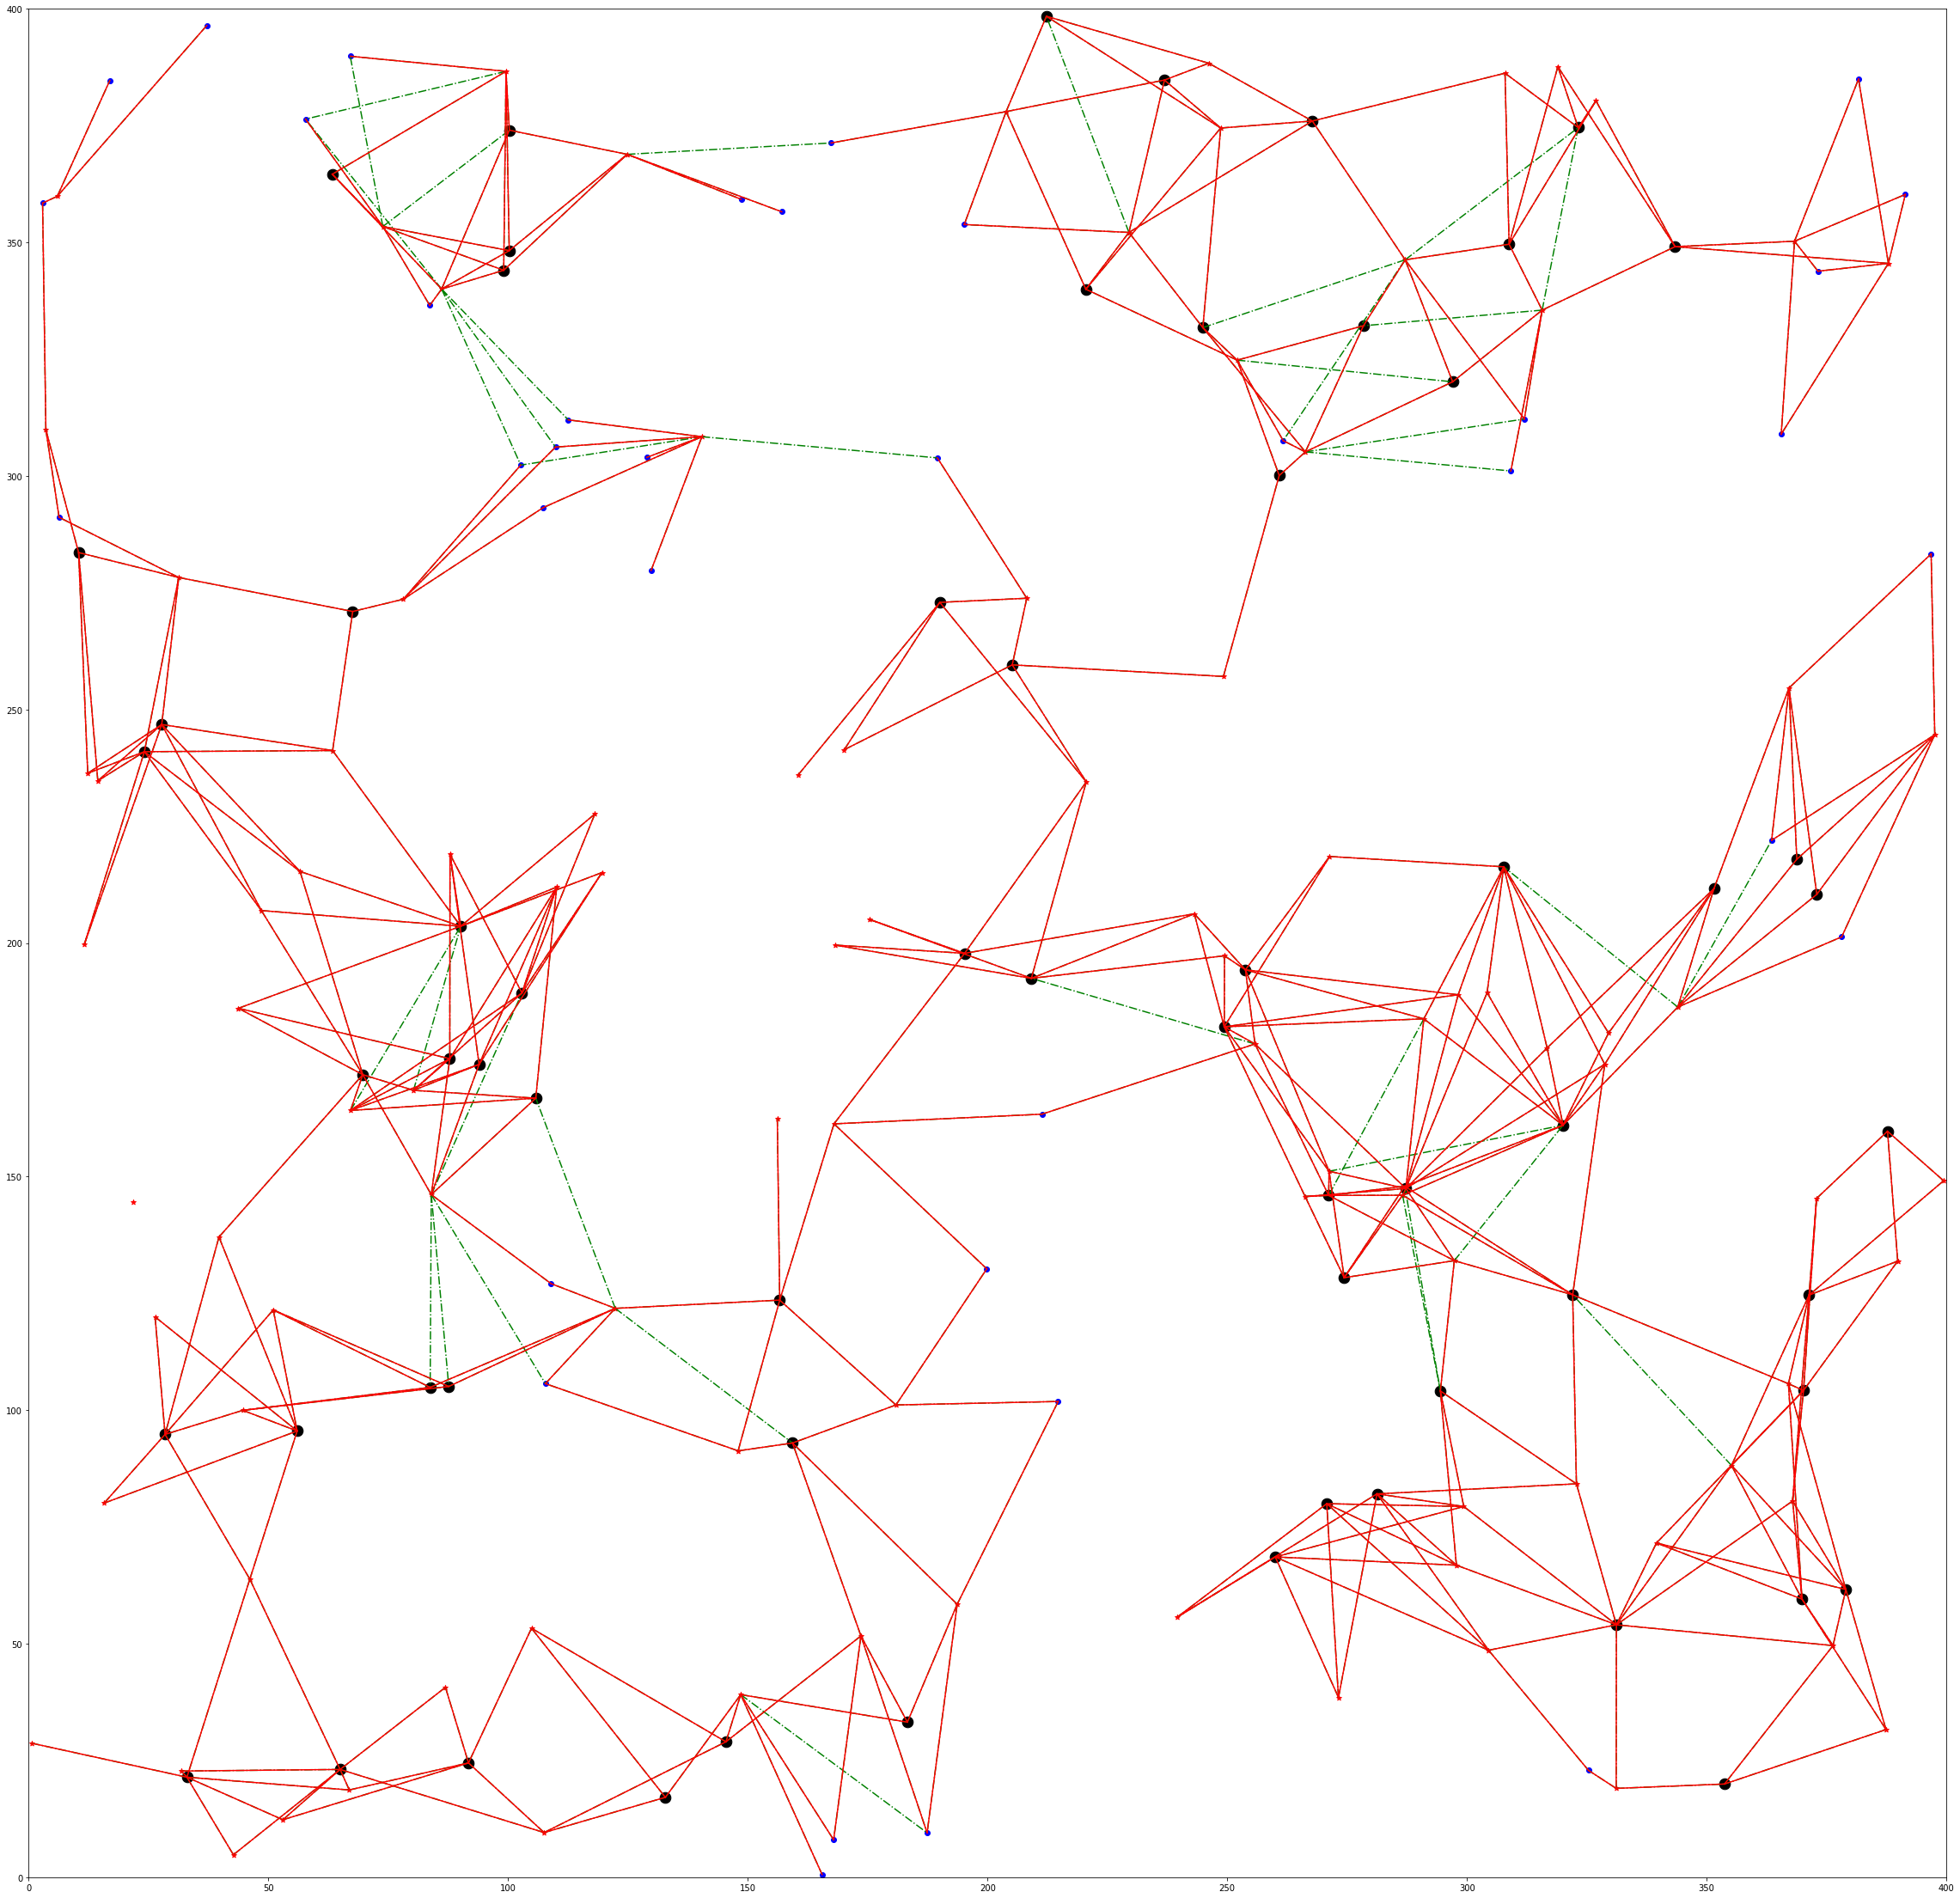

In [9]:
def greedy(sensors, clients, distances):
    sensor_connecttion = np.zeros((NUM_OF_SENSORS,1))
    client_connecttion = np.zeros((NUM_OF_CLIENTS,1))
    connection_matrix = np.zeros((NUM_OF_SENSORS, NUM_OF_CLIENTS)) # connects_matrix[i][j]=1 代表i号sensor决定连接j号client
    # 这个函数用来储存每个sensor连接其检测能力下的最近的n个client, 也可以说是决定连接的client,不过没有必要最终使得每个决定连接的client都有足够多（CLIENT_CONNECT_NEED）个server连接
                
    for i in range(NUM_OF_SENSORS):
        sortdist = np.sort(distances[i])
        for j in np.argsort(distances[i])[:min(SERVERS_CONNECT_ABILITY,len(sortdist[sortdist <= SENSOR_DISTANCE]))]:
            sensor_connecttion[i][0] += 1
            client_connecttion[j][0] += 1
            assert connection_matrix[i][j] == 0
            connection_matrix[i][j] = 1

    '''
    potentialConnect = {}
    potentialConnectDist = {}
    potentialConnectFlag = {}
    for i in range(NUM_OF_SENSORS):
        length = len(np.argwhere(distances[i,:] <= SENSOR_DISTANCE).reshape(1,-1)[0])
        potentialConnect[i] = (distances[i,:]).argsort()[:length]
        potentialConnectDist[i] = distances[i,:][(distances[i,:]).argsort()][:length]
        potentialConnectFlag[i] = np.zeros((length,1))
    '''
    num_of_success_clients = len(client_connecttion[client_connecttion>=CLIENT_CONNECT_NEED])
    
    return connection_matrix, num_of_success_clients




connection_matrix, num_of_success_clients =  greedy(sensors, clients, distances)
print(num_of_success_clients)
draw_picture(sensors, clients, distances, connection_matrix)

## GA启发式

100%|██████████| 100/100 [00:00<00:00, 596.83it/s]


68


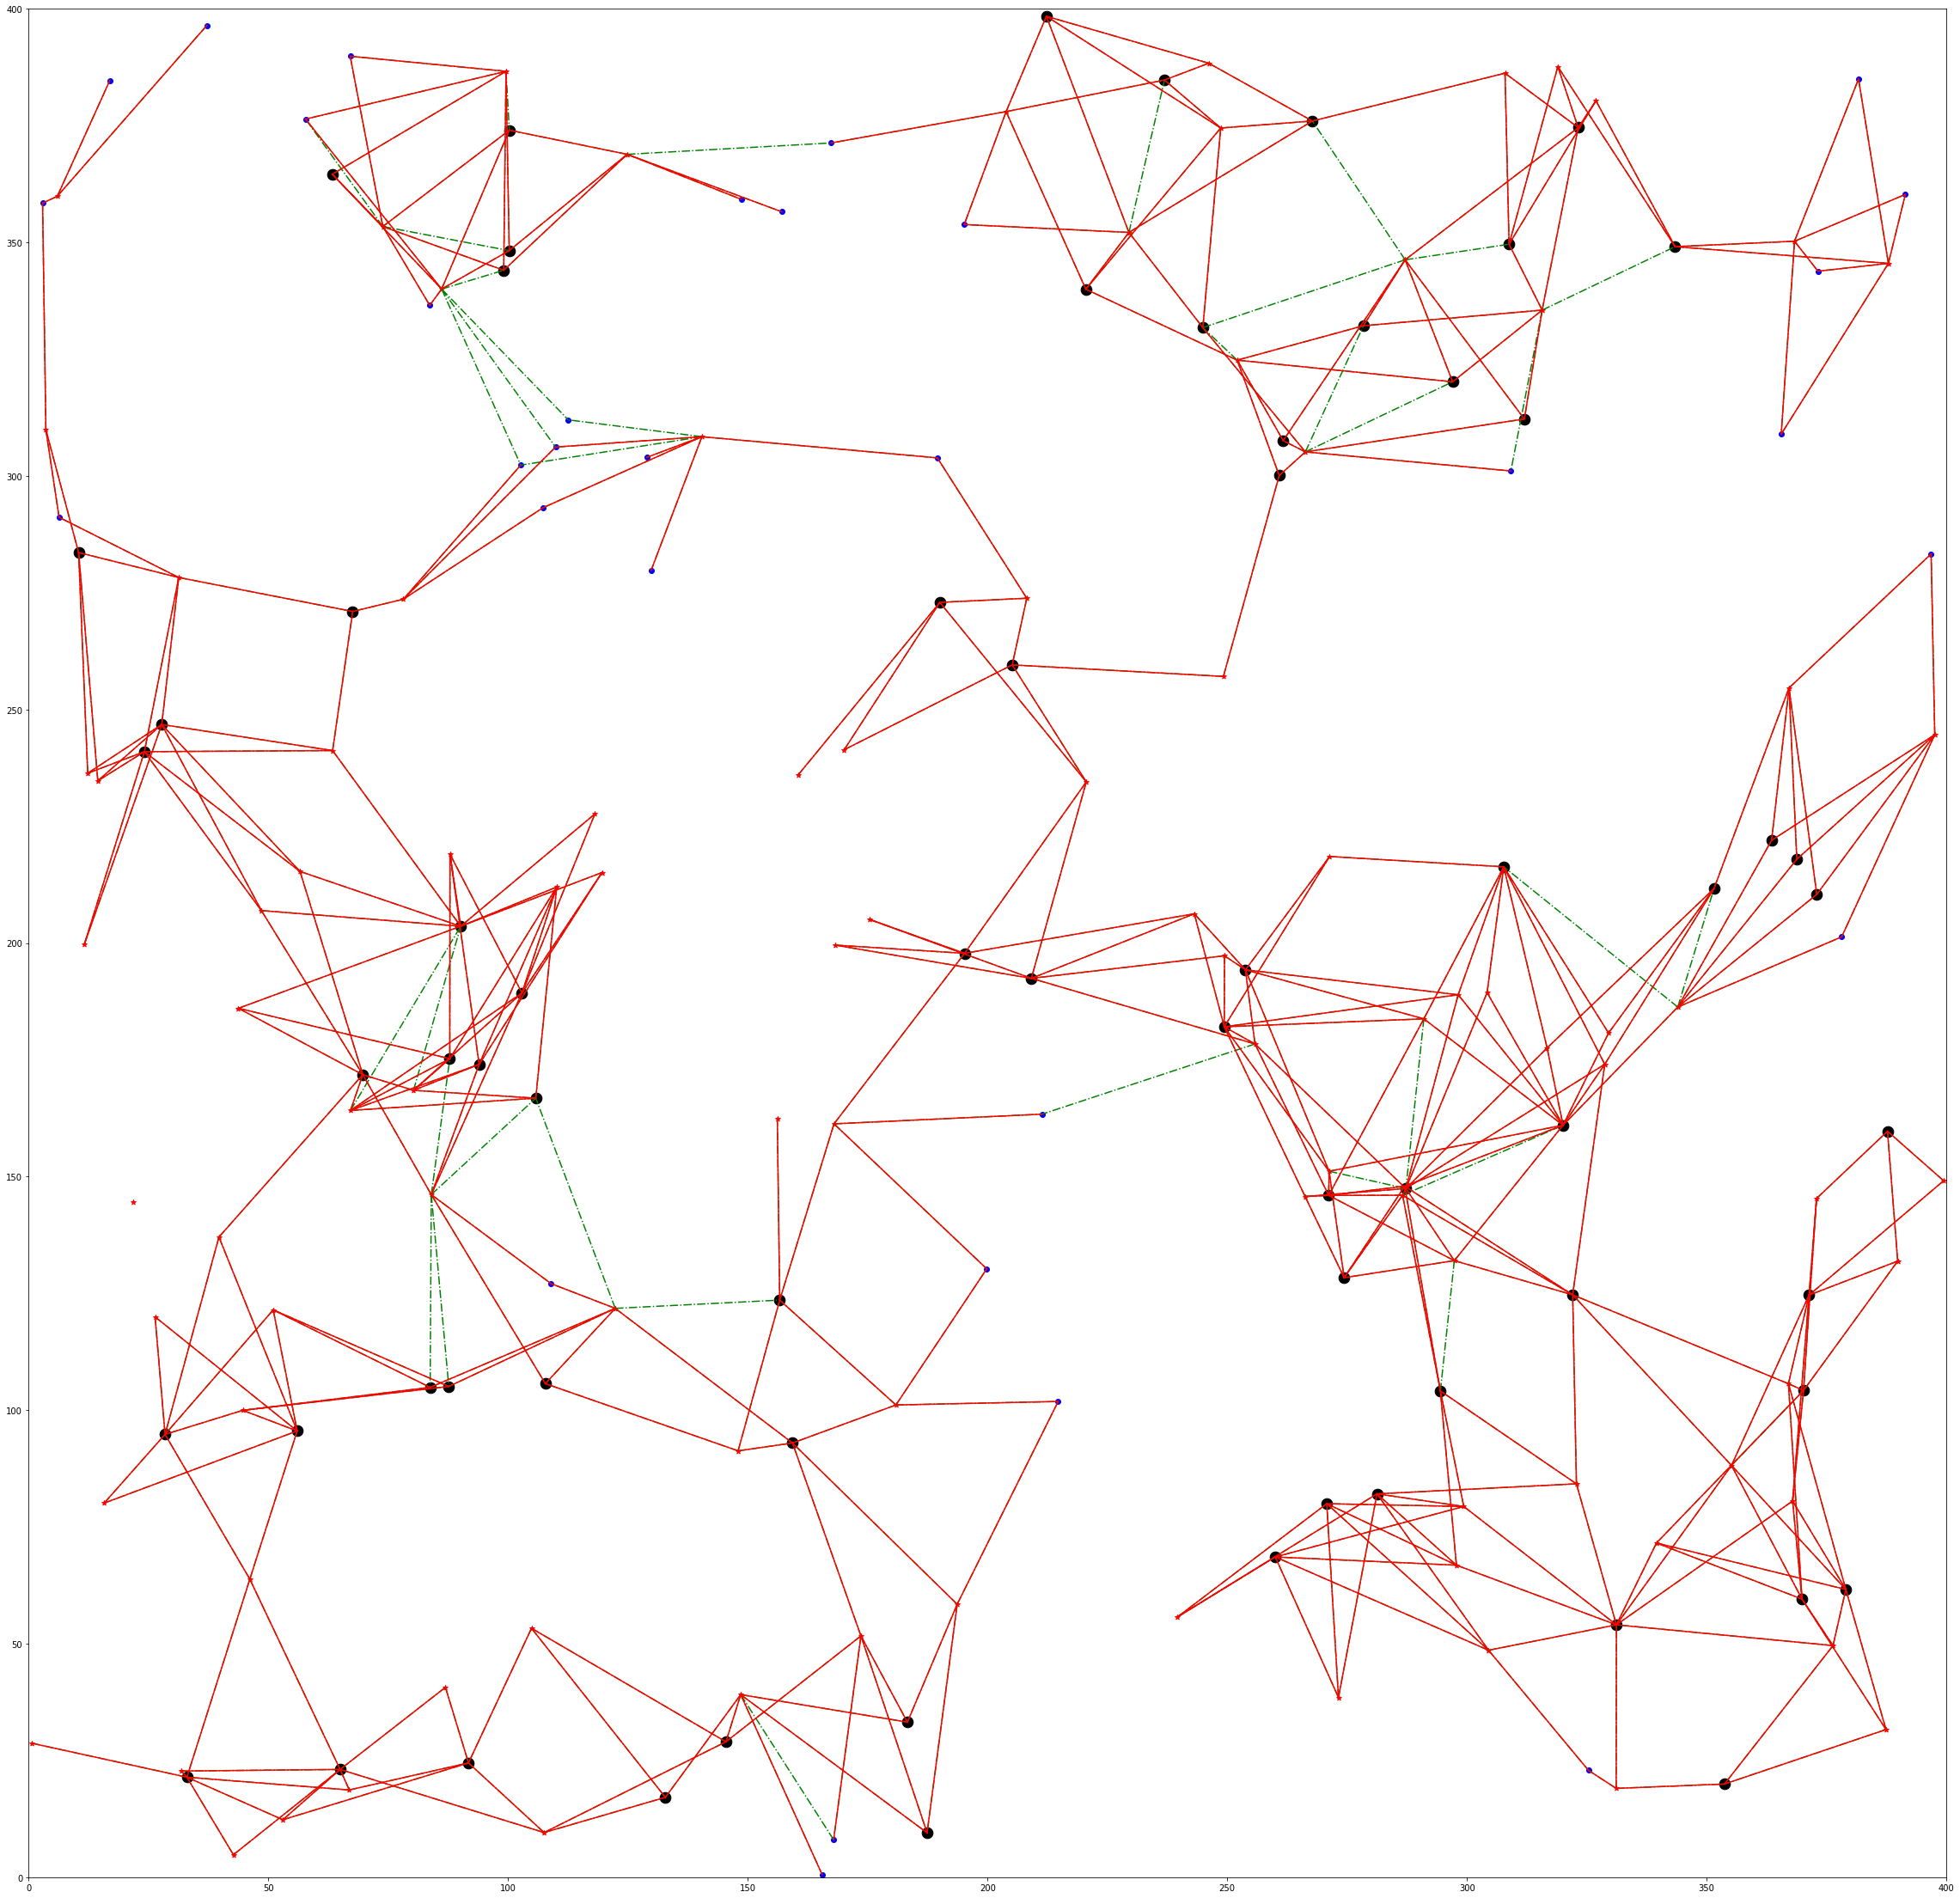

In [64]:

def GA(sensors, clients, distances):
    potentialConnect = {}
    potentialConnectDist = {}
    potentialConnectFlag = {}
    for i in range(NUM_OF_SENSORS):
        length = len(np.argwhere(distances[i,:] <= SENSOR_DISTANCE).reshape(1,-1)[0])
        potentialConnect[i] = (distances[i,:]).argsort()[:length] 
        potentialConnectDist[i] = distances[i,:][(distances[i,:]).argsort()][:length] 
        potentialConnectFlag[i] = np.zeros((length,1))

    connetion = np.zeros((NUM_OF_SENSORS,NUM_OF_CLIENTS))
    Gene = []
    PotentialGene = []
    for key in potentialConnect.keys():
        if len(potentialConnect[key]) <= SERVERS_CONNECT_ABILITY:
            for i in potentialConnect[key]:
                connetion[key][i] = 1
        else:
            Gene.append(key)
            PotentialGene.append(potentialConnect[key])

    def measureConnection(connetion):
        return np.sum(np.sum(connetion,axis=0)>=CLIENT_CONNECT_NEED)

    def measureGene(sole):
        tmpConnect = copy.deepcopy(connetion)
        for i in range(len(Gene)):
            for j in sole[i]:
                tmpConnect[Gene[i]][j] = 1
        return measureConnection(tmpConnect)

    def crossover_and_mutation(pop, CROSSOVER_RATE = 0.5):
        new_pop = []
        for father in pop:  
            child = father  
            if np.random.rand() < CROSSOVER_RATE: 
                mother = pop[np.random.randint(SIZE)]  
                cross_points = np.random.randint(0, len(child))  
                child[cross_points:] = mother[cross_points:] 
            mutation(child)  
            new_pop.append(child)
        return new_pop

    def mutation(child, MUTATION_RATE= 0.1):
        if np.random.rand() < MUTATION_RATE:  
            mutate_point = np.random.randint(0, len(child))  
            child[mutate_point] =  np.random.choice(PotentialGene[mutate_point],5, replace=False)

    def get_fitness(ranks): 
        return ((np.array(ranks) - min(ranks) )* 2) ** 2 + 1e-3 


    def select(pop, fitness):    # nature selection wrt pop's fitness
        idx = np.random.choice(np.arange(SIZE), size=SIZE, replace=True,
                               p=(fitness)/(fitness.sum()) )
        return [pop[i] for i in idx]
    Pop = []
    Rank = []
    
    for leng in trange(SIZE):
        sole = []
        tmpConnect = copy.deepcopy(connetion)
        for i in range(len(Gene)):
            snrs = np.random.choice(PotentialGene[i],5, replace=False)
            sole.append(snrs)
            for j in snrs:
                tmpConnect[Gene[i]][j] = 1
        Pop.append(sole)
        Rank.append(measureConnection(tmpConnect))

    maxitem = Pop[Rank.index(max(Rank))]
    maxium = max(Rank)
    RankRec = []

    for _ in trange(maxiter):
        Pop = crossover_and_mutation(Pop)
        ranks = [0 for i in range(SIZE)]
        for i in range(SIZE):
            ranks[i] = measureGene(Pop[i])

        if max(ranks) >= maxium:
            maxium = max(ranks)
            maxitem = copy.deepcopy(Pop[ranks.index(max(ranks))])
        Pop[ranks.index(min(ranks))] = copy.deepcopy(maxitem) 
        ranks[ranks.index(min(ranks))] = maxium
        if _ == maxiter:
            break

        fitness = get_fitness(ranks)

        Pop = select(Pop, fitness)
        RankRec.append(max(ranks))

    
    sole = maxitem
    
    tmpConnect = copy.deepcopy(connetion)
    for i in range(len(Gene)):
        for j in sole[i]:
            tmpConnect[Gene[i]][j] = 1


        
    return tmpConnect, np.sum(np.sum(tmpConnect,axis=0)>=3), RankRec




connection_matrix, num_of_success_clients, RankRec =  GA(sensors, clients, distances)
print(num_of_success_clients)
draw_picture(sensors, clients, distances, connection_matrix)

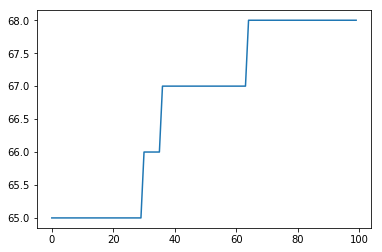

In [65]:
plt.plot(RankRec)